# Introduction

Last chapter we see how DQN works. This chapter we take a look at hwat could be done to improve DQN. We will introduce Double-DQN and Duel-DQN, with slight modification based on DQN and significant improvement on performance.

# Double DQN
The standard DQN is notoriously famous for its possible overestimation on $Q$. Why is so? The TD estimation of DQN is $r + \gamma \max_{a'} Q_{\omega^-}(s', a')$. We can also write $\max_{a'} Q_{\omega^-}(s', a')$ as $$Q_{\omega^-}(s', \max_{a'} Q_{\omega^-}(s', a')).$$ In other words, the $\max$ operation here can be divided into 2 steps: 1. select the best action $s'$ under state $s$, and 2. calculate the corresponding value $Q_\omega(s', a')$. Using the same Q-netowrk for the two calculation, each time we will get the maximum under current estimation. Since the network may have positive or negative bias, it is easy to see that the positive bias will be accumulated. For a large action space, such deficiency may break DQN totally. 

Motivative by this idea, Double-DQN solves the overestimation issue by use 2 networks for esitmation: $$Q_{\omega^-}(s', \max_{a'} Q_{\omega}(s', a')),$$ where $Q_{\omega^-}$ and $Q_{\omega}$ are 2 different networks. By doing so, although $Q_{\omega}$ may still overstimate every time, $Q_{\omega^-}$ could have either positive or negative bias, which alleviates the overestimation. 

In traditional DQN, since we already have 2 Q-networks, we can directly use the training network for action selection, and the target network for value estimation. We can write out the optimization object directly:  $$ r + \gamma  * Q_{\omega^-}(s', \max_{a'} Q_{\omega}(s', a'))$$

# Inverted Pendulum env
In this chapter we will take a look at the inverted pendulum env. This env has a inverted pendulum, whose position is at random. The state includes the sine, cosine value of the angle $\theta$ of the pendulum as well as its angular velocity $\dot{\theta}$. The action is the torque applied to the pendulum. The reward $r = -(\theta^2 + 0.1\dot{\theta} +0.001a^2)$, which will be 0 when the pendulum is upward still, and negative for all other cases. The env has no termination, and will be truncated after 200 steps.

The torque in the definition is continuous. Though DQN itself does not process continuous action space, we still want to use it here to show the harm of overestimation via this environment. Hence, we can descretize the action space from $[-2, 2]$ to $\{-2, -1.6, -1.2, ..., 2\}$ 11 actions, represented by $[0,1, ..., 10]$.

In [25]:
import numpy as np
np.bool8 = np.bool_
import random
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
import collections

class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, terminated, truncated):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, terminated, truncated))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, terminated, truncated = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), terminated, truncated

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [ ]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device, final_epsilon=0.01, decay_rate=0.9, type="DQN"):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)
        
        # make the two Q nets has the same init param
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device
        self.final_epsilon = final_epsilon
        self.decay_rate = decay_rate
        self.dqn_type = type

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        # print(state)
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = torch.argmax(self.q_net(state), dim=1).numpy()[0]
        return action
    
    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        # implement Double DQN
        states = torch.tensor(transition_dict["states"], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict["actions"], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict["rewards"], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict["next_states"], dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict["terminated"], dtype=torch.float).to(self.device)
        truncated = torch.tensor(transition_dict["truncated"], dtype=torch.float).to(self.device)
        
        # update here for double DQN
        if self.dqn_type == 'DoubleDQN':
            res = self.q_net(next_states)
            _, max_q_actions = torch.max(res, dim=1)
            max_q_actions = max_q_actions.unsqueeze(1)
            with torch.no_grad():
                max_q = self.target_q_net(states).gather(1, max_q_actions.long()).squeeze()
        else:
            with torch.no_grad():
                res = self.target_q_net(next_states)
            max_q, _ = torch.max(res, dim=1)
        td_est = rewards.squeeze() + self.gamma * max_q * (1 - terminated).squeeze() * (1 - truncated).squeeze()
        q_values = self.q_net(states).gather(1, actions.long()).squeeze()
        dqn_loss = torch.mean(F.mse_loss(q_values, td_est)) # mean squared loss
        
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # for name, param in self.q_net.named_parameters():
        #     if param.grad is None:
        #         print(f"[No Grad] {name}")
        #     else:
        #         print(f"[Has Grad] {name} | Mean grad: {param.grad.abs().mean().item():.6f}")

        # grad_norm = sum(p.grad.data.norm(2).item() ** 2 for p in self.q_net.parameters()) ** 0.5
        # print(f"Gradient norm: {grad_norm:.4f}")

        # update the target network if C steps passed
        self.epsilon = max(self.final_epsilon, self.epsilon * self.decay_rate)

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) 
        self.count += 1
        return dqn_loss.detach().item()

In [41]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

In [42]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])

                    done = terminated or truncated

                    replay_buffer.add(state, action, reward, next_state, terminated, truncated)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_ter, b_tru = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'terminated': b_ter,
                            'truncated': b_tru
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:01<00:00, 14.27it/s, episode=200, return=-135.759]


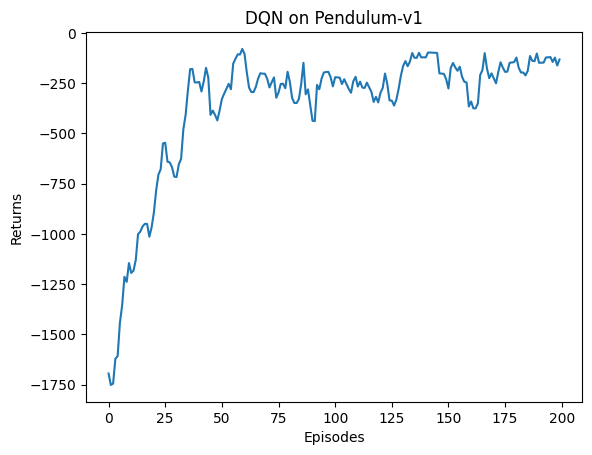

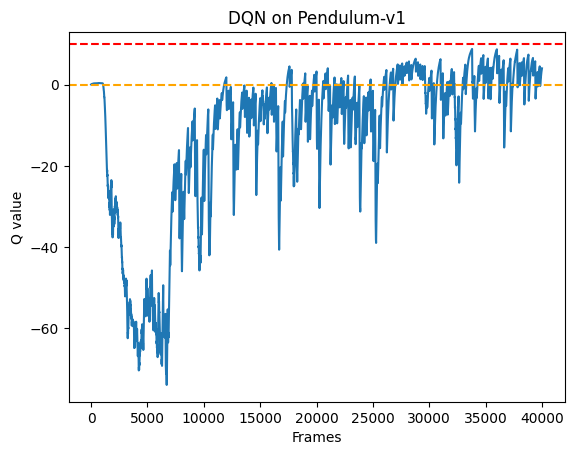

In [43]:
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

From the result we can see DQN is doing not bad in this task, but the estimation of $Q$ may be over 0, which is impossible since by definition all the rewards are non-positive. Now Let's see how Double DQN does.

Iteration 9: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s, episode=200, return=-1289.012]


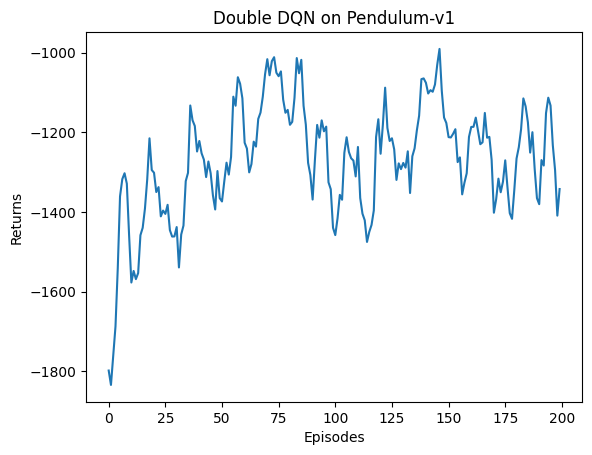

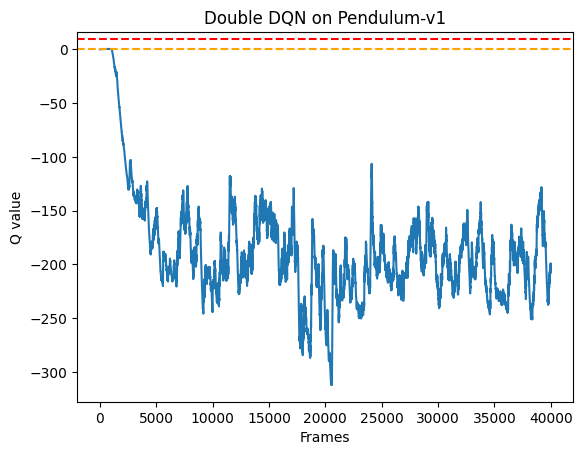

In [46]:
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, type='DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()